[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XanaduAI/GradDFT/blob/main/examples/intermediate_notebooks/periodic_systems_bz_sampling_05.ipynb)

In [ ]:
# In colab run
# !pip install git+https://github.com/XanaduAI/GradDFT.git

# Periodic systems with k-point sampling in Grad DFT

In this tutorial, you will learn how to train a simple neural functional for solids with full integration over the 1BZ. Calculations in this tutorial are certainly not converged with respect to k-point sampling or basis sets, so please consider this when adapting to your own calculations.

## Perform solid-state calculations with PySCF

PySCF implements DFT and some wavefunction methods in periodic boundary conditions with integration over the 1BZ. To begin, we need:

(1) A DFT starting point to prime Grad DFT. We'll use the PBE functional.

(2) Accurate training and validation data. We'll use the periodic CCSD solver implemented in PySCF.

Our calculations will be run using Sodium Chloride (NaCl) in the rock salt structure.

Let's import the modules required for the PySCF pre-computations.

In [1]:
from pyscf.pbc import gto, scf, mp, cc
import numpy as np

/Users/pablo.casares/miniforge3/envs/graddft/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Next, we define the primitive cell for NaCl in the Rocksalt struture. This structural data was taken from [The Materials Project](https://next-gen.materialsproject.org/materials/mp-22862). 

We will train using the pristine geometry and validate using a slightly expanded cell.

In [2]:
# Training geometry: pristine NaCl

param = 5.272336
lat_vec = np.array(
    [
        [0.0, param, param],
        [param, 0.0, param],
        [param, param, 0.0]
    ]
)

cell_tr = gto.M(
    a = lat_vec,
    atom = """Na 0.0 0.0 0.0
              Cl %.5f %.5f %.5f""" % (param, param, param),
    basis = 'sto-3g',
)
cell_tr.exp_to_discard=0.1

# Validation geometry: NaCl with a 5% larger lattice parameter

param_strain = param*1.05
lat_vec_strain = np.array(
    [
        [0.0, param_strain, param_strain],
        [param_strain, 0.0, param_strain],
        [param_strain, param_strain, 0.0]
    ]
)
cell_val = gto.M(
    a = lat_vec_strain,
    atom = """Na 0.0 0.0 0.0 
              Cl %.5f %.5f %.5f""" % (param_strain, param_strain, param_strain),
    basis = 'sto-3g'
)
cell_val.exp_to_discard=0.1

Next, we get the DFT starting point to prime Grad DFT. We use PBE and a small number of k-points. We also use Gaussian density fitting for the electronic coulomb terms. [All other PBC density fitting approaches](https://pyscf.org/user/pbc/df.html) in PySCF are also compatible with Grad DFT.

In [3]:
# Run training DFT starting point
kmf_tr = scf.KRKS(cell_tr, kpts=cell_tr.make_kpts([2,2,2])).density_fit()
kmf_tr.xc = "PBE"
kmf_tr.max_cycle = 10
kmf_tr = kmf_tr.run()

# Run validation DFT starting point
kmf_val = scf.KRKS(cell_val, kpts=cell_val.make_kpts([2,2,2])).density_fit()
kmf_val.xc = "PBE"
kmf_val.max_cycle = 10
kmf_val = kmf_val.run()

<class 'pyscf.pbc.dft.krks.KRKS'> does not have attributes  nlcgrids nlc



WARN: HOMO 0.133342844043 == LUMO 0.133342844043


WARN: HOMO 0.129696510302 == LUMO 0.129696796143


WARN: HOMO 0.123485609714 == LUMO 0.123533794981


WARN: HOMO 0.122470342913 == LUMO 0.122549417589


WARN: HOMO 0.121977200489 == LUMO 0.121984450283


WARN: HOMO 0.127199590342 == LUMO 0.127215372837


WARN: HOMO 0.127429516524 == LUMO 0.127576695046

SCF not converged.
SCF energy = -613.999831522497

WARN: HOMO 0.136411628811 == LUMO 0.136411628812


WARN: HOMO 0.113400677255 == LUMO 0.113620213224


WARN: HOMO 0.114848903144 == LUMO 0.115097636252


WARN: HOMO 0.178814138743 == LUMO 0.17892358234


WARN: HOMO 0.180008068011 == LUMO 0.180066156279


WARN: HOMO 0.179951129106 == LUMO 0.179972904236

SCF not converged.
SCF energy = -613.984277821783


Now we can perform the CCSD calculations which will be used for truth values in training.

In [4]:
# Make one training data-point and one validation using CCSD

# Training
khf_tr = scf.KRHF(cell_tr, kpts=cell_tr.make_kpts([2,2,2])).density_fit()
khf_tr = khf_tr.run()
ccsd_tr = cc.KCCSD(khf_tr)
ccsd_tr = ccsd_tr.run()
E_tr = ccsd_tr.e_tot


# Validation
khf_val = scf.KRHF(cell_val, kpts=cell_val.make_kpts([2,2,2])).density_fit()
khf_val = khf_val.run()
ccsd_val = cc.KCCSD(khf_val)
ccsd_val = ccsd_val.run()
E_val = ccsd_val.e_tot


converged SCF energy = -614.443314677291
E(RCCSD) = -614.4825393595149  E_corr = -0.03922468222342719
converged SCF energy = -614.434597523731
E(RCCSD) = -614.4738196894269  E_corr = -0.03922216569629406


## Loading into Grad DFT

The DFT starting points from PySCF can be loaded into Grad DFT with the convenience function `solid_from_pyscf`. This mirrors `molecule_from_pyscf` but now many arrays have an additional k-points dimension.

In [5]:
from jax.config import config
config.update("jax_enable_x64", True)
import grad_dft as gd

gd_sol_tr = gd.solid_from_pyscf(kmf_tr)
gd_sol_val = gd.solid_from_pyscf(kmf_val)

Instructions for updating:
non-resource variables are not supported in the long term


## Make a simple neural functional

Like in `~/examples/intermediate_notebooks/training_methods_03.ipynb`, we create a scaled down version of the net used the original Grad DFT reference article

In [6]:
from grad_dft.functional import canonicalize_inputs, dm21_coefficient_inputs, dm21_densities
from jax.nn import gelu
from functools import partial
import jax.numpy as jnp
from jax.random import PRNGKey

seed = 1984 # Random seed used throughout this notebok for reproducibility reasons.
key = PRNGKey(seed)

squash_offset = 1e-4
layer_widths = [6] * 2

out_features = 2
sigmoid_scale_factor = 2.0
activation = gelu

def nn_coefficients(instance, rhoinputs, *_, **__):
    x = canonicalize_inputs(rhoinputs)  # Making sure dimensions are correct
    # Initial layer: log -> dense -> tanh
    x = jnp.log(jnp.abs(x) + squash_offset)  # squash_offset = 1e-4
    instance.sow("intermediates", "log", x)
    x = instance.dense(features=layer_widths[0])(x)  # features = 256
    instance.sow("intermediates", "initial_dense", x)
    x = jnp.tanh(x)
    instance.sow("intermediates", "norm", x)
    # 2 Residual blocks with 6-features dense layer and layer norm
    for features, i in zip(layer_widths, range(len(layer_widths))):  # layer_widths = [256]*6
        res = x
        x = instance.dense(features=features)(x)
        instance.sow("intermediates", "residual_dense_" + str(i), x)
        x = x + res  # nn.Dense + Residual connection
        instance.sow("intermediates", "residual_residual_" + str(i), x)
        x = instance.layer_norm()(x)  # + res # nn.LayerNorm
        instance.sow("intermediates", "residual_layernorm_" + str(i), x)
        x = activation(x)  # activation = jax.nn.gelu
        instance.sow("intermediates", "residual_elu_" + str(i), x)
    return instance.head(x, out_features, sigmoid_scale_factor)
        
functional = gd.NeuralFunctional(
    coefficients=nn_coefficients,
    coefficient_inputs=dm21_coefficient_inputs,
    energy_densities=partial(dm21_densities, functional_type="GGA"),
)

## Non self-consistent training using the energy only

Once again, borrowing from `~/examples/intermediate_notebooks/training_methods_03.ipynb`, we define a training and validation regime

In [7]:
from optax import adam, apply_updates
from tqdm import tqdm
from jax import value_and_grad

def train_neural_functional(train_recipe: tuple, validate_recipe: tuple) -> None:
    r"""Minimize a Grad DFT loss function using 50 epochs of the Adam optimizer.

    Args:
        train_recipe (tuple):train_recipe (tuple): information regarding the loss, its arguments and the predictor.
        validate_recipe (tuple):train_recipe (tuple): the same information as train_recipe, but for the validation calculation.
    Returns:
        tuple: the training and validation loss history over the number of training epochs
    """
    
    loss_func, loss_args = train_recipe
    val_func, val_args = validate_recipe
    
    tr_params = functional.init(key, dm21_coefficient_inputs(loss_args[2][0]))
    loss_args[0] = tr_params
    val_args[0] = tr_params
    
    tx = adam(learning_rate=0.01, b1=0.9)
    opt_state = tx.init(tr_params)
    loss_and_grad = value_and_grad(loss_func)
    tr_loss_history = []
    val_loss_history = []
    for i in tqdm(range(10), desc="Training epoch"):
        tr_loss_value, grads = loss_and_grad(*loss_args)
        val_loss_value = val_func(*val_args)
        tr_loss_history.append(tr_loss_value)
        val_loss_history.append(val_loss_value)
        updates, opt_state = tx.update(grads, opt_state, tr_params)
        tr_params = apply_updates(tr_params, updates)
        loss_args[0] = tr_params
        val_args[0] = tr_params
        if (i + 1) % 5 == 0:
            print(f"At epoch {i+1} training loss = {tr_loss_value}, validation loss = {val_loss_value}")
    return tr_loss_history, val_loss_history
   

In [8]:
non_sc_en_train_recipe = (
    gd.mse_energy_loss, 
    [None, gd.non_scf_predictor(functional), [gd_sol_tr], [E_tr], True]
)
non_sc_en_validate_recipe = (
    gd.mse_energy_loss, 
    [None, gd.non_scf_predictor(functional), [gd_sol_val], [E_val], True]
)

Now we can perform the non-self consistent training.

In [9]:
# Begin training
tr_loss_his_non_sc_en, val_loss_his_non_sc_en = train_neural_functional(non_sc_en_train_recipe, non_sc_en_validate_recipe)

Training epoch:  50%|█████     | 5/10 [01:11<01:08, 13.70s/it]

At epoch 5 training loss = 0.00021681184278852755, validation loss = 0.00022157386004632528


Training epoch: 100%|██████████| 10/10 [02:17<00:00, 13.78s/it]

At epoch 10 training loss = 3.611312949052283e-07, validation loss = 1.7956748122185697e-07


and check out the loss as a function of epochs

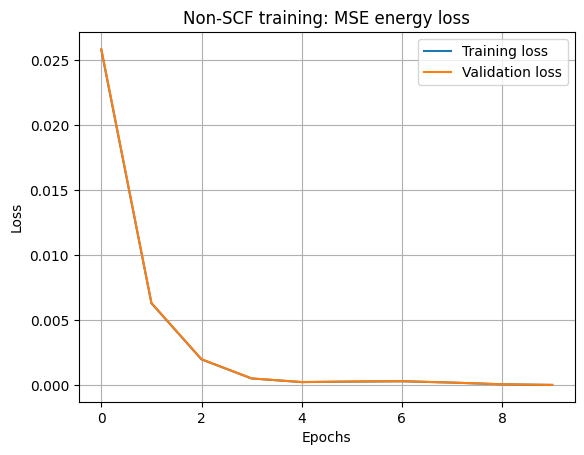

In [10]:
import matplotlib.pyplot as plt

plt.plot(tr_loss_his_non_sc_en, label="Training loss")
plt.plot(val_loss_his_non_sc_en, label="Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Non-SCF training: MSE energy loss")
plt.grid()
plt.legend()

## Self-consistent training using the energy only

Training can also be performed in self consistent mode. Solids are presently supported in the linear mixing code: `gd.diff_simple_scf_loop`.


In [11]:
sc_en_train_recipe = (
    gd.mse_energy_loss, 
    [None, gd.diff_simple_scf_loop(functional, cycles=5), [gd_sol_tr], [E_tr], True]
)
sc_en_validate_recipe = (
    gd.mse_energy_loss, 
    [None, gd.diff_simple_scf_loop(functional, cycles=5), [gd_sol_val], [E_val], True]
)

In [12]:
# Begin training
tr_loss_his_sc_en, val_loss_his_sc_en = train_neural_functional(sc_en_train_recipe, sc_en_validate_recipe)

Training epoch:  50%|█████     | 5/10 [10:38<10:36, 127.31s/it]

At epoch 5 training loss = 0.00012283809515136498, validation loss = 0.00012489890222459223


Training epoch: 100%|██████████| 10/10 [21:38<00:00, 129.80s/it]

At epoch 10 training loss = 0.00016523055544214686, validation loss = 0.00016298261790833693


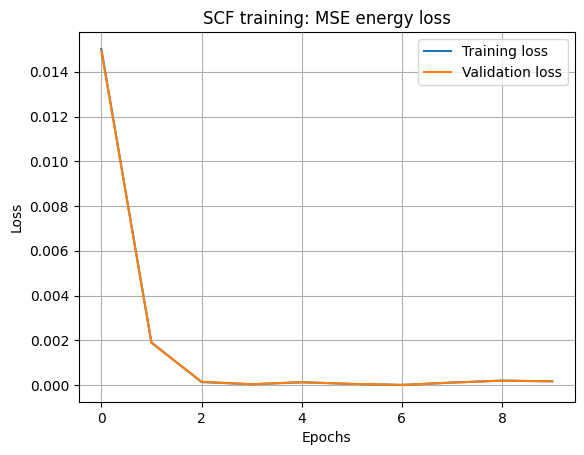

In [13]:
import matplotlib.pyplot as plt

plt.plot(tr_loss_his_sc_en, label="Training loss")
plt.plot(val_loss_his_sc_en, label="Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("SCF training: MSE energy loss")
plt.grid()
plt.legend()